In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, accuracy_score
from datetime import timedelta

pd.set_option('precision', 3)
import warnings
warnings.filterwarnings('ignore')
import shap

pd.set_option('display.max_rows', 20)
from matplotlib import rc,cm
from matplotlib import colors


In [3]:
sys.path.insert(1, './utils')
import xgboost_wrapper as xw
import stratify as st
import AMR_functions as af
import utils as ut
import shap_summary_plot as ssp
import auc_boot as ab

In [15]:
def subplotlabel(response_name):
    if response_name == 'AUG':
        return 'A'
    elif response_name == 'CIP':
        return 'B'
    elif response_name == 'MEM':
        return 'C'    
    elif response_name == 'TAZ':
        return 'D'
    else:
        return response_name

# Dataset

In [16]:
pharma_lab_demo_df_ = pd.read_pickle('../../pharma_lab_demo_df_grouped.pkl')

In [17]:
pharma_lab_demo_df_.duplicated().any()

False

In [18]:
pharma_lab_demo_df_ = af.bool_to_int(pharma_lab_demo_df_)

The dataset is multivariate collection of stills in the form of a data matrix, rows correspond to stills and columns to features associatiated with the still.
The abbreviated features names are:        

In [19]:
pharma_lab_demo_df_.columns.values

array(['ADMIDATE', 'AUG_prev_prescr', 'GT_prev_prescr', 'CIP_prev_prescr',
       'MEM_prev_prescr', 'ETP_prev_prescr', 'CAZ_prev_prescr',
       'CTX_prev_prescr', 'AK_prev_prescr', 'ATM_prev_prescr',
       'TEM_prev_prescr', 'TAZ_prev_prescr', 'AMP', 'AUG', 'GT', 'CIP',
       'CPD', 'TAZ', 'MEM', 'ETP', 'CAZ', 'CTX', 'TEM', 'AK', 'ATM',
       'COL', 'AMP_r_prev', 'AMP_s_prev', 'AUG_r_prev', 'AUG_s_prev',
       'GT_r_prev', 'GT_s_prev', 'CIP_r_prev', 'CIP_s_prev', 'CPD_r_prev',
       'CPD_s_prev', 'TAZ_r_prev', 'TAZ_s_prev', 'MEM_r_prev',
       'MEM_s_prev', 'ETP_r_prev', 'ETP_s_prev', 'CAZ_r_prev',
       'CAZ_s_prev', 'CTX_r_prev', 'CTX_s_prev', 'TEM_r_prev',
       'TEM_s_prev', 'AK_r_prev', 'AK_s_prev', 'ATM_r_prev', 'ATM_s_prev',
       'COL_r_prev', 'COL_s_prev', 'any_abx_r_prev', 'n_days',
       'total_days_in_hospitals', 'fraction_days_in_hospitals',
       'number_of_hospital_visits', 'age', 'n_comorb', 'SDG_104',
       'SDG_105', 'SDG_106', 'SDG_11', 'SDG_128', 'SDG_

The features whose names begin with `SDG_` (SHMI diagnosis groups), `ADMIMETH_`, and `CONSPEF_` are binary variables and correspond to commorbidites, admission methods, and consultant specialties, respectively. The dictionaries for these codes are:

In [20]:
comorbitities_features = ['SDG_104', 'SDG_105', 'SDG_106', 'SDG_11', 'SDG_128',
       'SDG_19', 'SDG_2', 'SDG_26', 'SDG_29', 'SDG_30', 'SDG_39', 'SDG_4',
       'SDG_40', 'SDG_42', 'SDG_54', 'SDG_56', 'SDG_58', 'SDG_70',
       'SDG_74', 'SDG_75', 'SDG_78', 'SDG_79', 'SDG_3', 'SDG_107',
       'SDG_119', 'SDG_68', 'SDG_83', 'SDG_88', 'has_fibrosis']
{c:st.code_to_diagnosis(c) for c in comorbitities_features}

{'SDG_104': 'diagnosis: Genital disorders (M)',
 'SDG_105': 'diagnosis: Genital disorders (F)',
 'SDG_106': 'diagnosis: Reprod. disorders (F)',
 'SDG_11': 'diagnosis: Cancer (rectum)',
 'SDG_128': 'diagnosis: Implant/graft',
 'SDG_19': 'diagnosis: Cancer (uterus)',
 'SDG_2': 'diagnosis: Septicaemia',
 'SDG_26': 'diagnosis: Lymphoma',
 'SDG_29': 'diagnosis: Cancer (therapy)',
 'SDG_30': 'diagnosis: Cancer (secondary)',
 'SDG_39': 'diagnosis: Anemia',
 'SDG_4': 'diagnosis: Mycoses',
 'SDG_40': 'diagnosis: White-cell diseases',
 'SDG_42': 'diagnosis: Mental disorders',
 'SDG_54': 'diagnosis: Heart-valve disorders',
 'SDG_56': 'diagnosis: Hypertension',
 'SDG_58': 'diagnosis: Coronary diseases',
 'SDG_70': 'diagnosis: Arterial diseases',
 'SDG_74': 'diagnosis: Bronchitis (acute)',
 'SDG_75': 'diagnosis: COPD/bronchiectasis',
 'SDG_78': 'diagnosis: Lung disorders',
 'SDG_79': 'diagnosis: Respiratory insuffic.',
 'SDG_3': 'diagnosis: Infection (unspecified)',
 'SDG_107': 'diagnosis: Infectio

In [21]:
admission_features = ['ADMIMETH_12',
       'ADMIMETH_24', 'ADMIMETH_2A', 'ADMIMETH_31', 'ADMIMETH_13',
       'ADMIMETH_22', 'ADMIMETH_23', 'ADMIMETH_2B', 'ADMIMETH_28',
       'ADMIMETH_11', 'ADMIMETH_2D', 'ADMIMETH_81', 'ADMIMETH_21']
{c:st.code_to_diagnosis(c)  for c in admission_features}

{'ADMIMETH_12': 'admim. Booked',
 'ADMIMETH_24': 'admim. Consultant clinic',
 'ADMIMETH_2A': 'admim. A&E other provider',
 'ADMIMETH_31': 'admim. Ante partum',
 'ADMIMETH_13': 'admim. Planned',
 'ADMIMETH_22': 'admim. GP',
 'ADMIMETH_23': 'admim. Bed bureau',
 'ADMIMETH_2B': 'admim. Transfer (emergency)',
 'ADMIMETH_28': 'admim. Other',
 'ADMIMETH_11': 'admim. Waiting list',
 'ADMIMETH_2D': 'admim. Other emergency',
 'ADMIMETH_81': 'admim. Transfer (non-emerg.)',
 'ADMIMETH_21': 'admim. A&E'}

In [22]:
consultant_features = ['CONSPEF_107', 'CONSPEF_410', 'CONSPEF_370', 'CONSPEF_103',
       'CONSPEF_104', 'CONSPEF_343', 'CONSPEF_173', 'CONSPEF_320',
       'CONSPEF_502', 'CONSPEF_501', 'CONSPEF_120', 'CONSPEF_361',
       'CONSPEF_307', 'CONSPEF_160', 'CONSPEF_330', 'CONSPEF_300',
       'CONSPEF_106', 'CONSPEF_303', 'CONSPEF_101', 'CONSPEF_430',
       'CONSPEF_800', 'CONSPEF_350', 'CONSPEF_301', 'CONSPEF_340',
       'CONSPEF_180', 'CONSPEF_100', 'CONSPEF_110']
{c:st.code_to_diagnosis(c)  for c in consultant_features}

{'CONSPEF_107': 'Cons. specialty not known',
 'CONSPEF_410': 'CONSPEF RHEUMATOLOGY',
 'CONSPEF_370': 'CONSPEF MEDICAL ONCOLOGY',
 'CONSPEF_103': 'Cons. specialty not known',
 'CONSPEF_104': 'Cons. specialty not known',
 'CONSPEF_343': 'Cons. specialty not known',
 'CONSPEF_173': 'Cons. specialty not known',
 'CONSPEF_320': 'CONSPEF CARDIOLOGY',
 'CONSPEF_502': 'CONSPEF GYNAECOLOGY',
 'CONSPEF_501': 'CONSPEF OBSTETRICS',
 'CONSPEF_120': 'CONSPEF ENT',
 'CONSPEF_361': 'CONSPEF NEPHROLOGY',
 'CONSPEF_307': 'Cons. specialty not known',
 'CONSPEF_160': 'CONSPEF PLASTIC SURGERY',
 'CONSPEF_330': 'CONSPEF DERMATOLOGY',
 'CONSPEF_300': 'CONSPEF GENERAL MEDICINE',
 'CONSPEF_106': 'Cons. specialty not known',
 'CONSPEF_303': 'CONSPEF CLINICAL HAEMATOLOGY',
 'CONSPEF_101': 'CONSPEF UROLOGY',
 'CONSPEF_430': 'CONSPEF GERIATRIC MEDICINE',
 'CONSPEF_800': 'CONSPEF CLINICAL ONCOLOGY',
 'CONSPEF_350': 'CONSPEF INFECTIOUS DISEASES',
 'CONSPEF_301': 'CONSPEF GASTROENTEROLOGY',
 'CONSPEF_340': 'CONSPEF R

Dictionary:

   * `AUG_prev_prescr`, `GT_prev_prescr`, `CIP_prev_prescr`, etc.,  binary variables, 1 if the  antibiotic has been prescribed before the current hospital event.
   * `ABX_AMP`, `ABX_AUG`, `ABX_GT`, `ABX_CIP`, etc., binary variables, 1 if the antibiotic in the name is currently used. 
   * `AMP_r_prev`,  `AUG_r_prev`, number of times resistance to the antibiotic was detected before the current hospital event.
   * `any_abx_r_prev`, same as before, but for any antibiotic.
   * `AMP_s_prev`, `AUG_s_prev`, number of times resistance to the antibiotic was tested before the current hospital event and resulted negative.
   * `total_days_in_hospitals`, cumulative numbers of days spent in hospital since the beginning of the study
   * `fraction_days_in_hospitals`,  fraction of days in hospital over the total time elapsed since the beginning of the study
   * `n_days` duration of the hospital stay in days.
   * `n_comorb` number of comorbidities of that patient on that episode (also including the comorbitities not for which we couldn't find the SDG key.
   * `ADMIDATE` Admission day, counted from 2007-11-05
   * `start_from_admi` interval between admission and ABX administration (dropped)
   * `interval` interval between admission and laboratory test (dropped)
   * `R_b72` (Boolean) is `interval` < timedelta(hours=72) 

   

In [23]:
ABX_features_1 = ['AUG_prev_prescr', 'GT_prev_prescr', 'CIP_prev_prescr',
       'MEM_prev_prescr', 'ETP_prev_prescr', 'CAZ_prev_prescr',
       'CTX_prev_prescr', 'AK_prev_prescr', 'ATM_prev_prescr',
       'TEM_prev_prescr', 'TAZ_prev_prescr']
ABX_features_2 = ['AMP_r_prev', 'AUG_r_prev', 'GT_r_prev', 'CIP_r_prev',
       'CPD_r_prev', 'TAZ_r_prev', 'MEM_r_prev', 'ETP_r_prev',
       'CAZ_r_prev', 'CTX_r_prev', 'TEM_r_prev', 'AK_r_prev',
       'ATM_r_prev', 'COL_r_prev']
ABX_features_3 = ['AMP_s_prev', 'AUG_s_prev', 'GT_s_prev', 'CIP_s_prev',
       'CPD_s_prev', 'TAZ_s_prev', 'MEM_s_prev', 'ETP_s_prev',
       'CAZ_s_prev', 'CTX_s_prev', 'TEM_s_prev', 'AK_s_prev',
       'ATM_s_prev', 'COL_s_prev']
ABX_features_4 = ['ABX_GT', 'ABX_AUG', 'ABX_CTX', 'ABX_CIP',
       'ABX_ETP', 'ABX_CAZ', 'ABX_ATM', 'ABX_TAZ', 'ABX_TEM', 'ABX_MEM',
       'ABX_AK']
ABX_features = ABX_features_1 + ABX_features_2 + ABX_features_3 + ABX_features_4 + ['any_abx_r_prev']
{c:st.code_to_diagnosis(c)  for c in ABX_features}

{'AUG_prev_prescr': 'AUG previously prescribed',
 'GT_prev_prescr': 'GT previously prescribed',
 'CIP_prev_prescr': 'CIP previously prescribed',
 'MEM_prev_prescr': 'MEM previously prescribed',
 'ETP_prev_prescr': 'ETP previously prescribed',
 'CAZ_prev_prescr': 'CAZ previously prescribed',
 'CTX_prev_prescr': 'CTX previously prescribed',
 'AK_prev_prescr': 'AK previously prescribed',
 'ATM_prev_prescr': 'ATM previously prescribed',
 'TEM_prev_prescr': 'TEM previously prescribed',
 'TAZ_prev_prescr': 'TAZ previously prescribed',
 'AMP_r_prev': 'resistance to AMP previously found',
 'AUG_r_prev': 'resistance to AUG previously found',
 'GT_r_prev': 'resistance to GT previously found',
 'CIP_r_prev': 'resistance to CIP previously found',
 'CPD_r_prev': 'resistance to CPD previously found',
 'TAZ_r_prev': 'resistance to TAZ previously found',
 'MEM_r_prev': 'resistance to MEM previously found',
 'ETP_r_prev': 'resistance to ETP previously found',
 'CAZ_r_prev': 'resistance to CAZ previousl

In [24]:
set([s.split('_')[0] for s in ABX_features_1]).intersection(
    set([s.split('_')[0] for s in ABX_features_2]).intersection(
    set([s.split('_')[0] for s in ABX_features_3]))
).intersection(
    set([s.split('_')[1] for s in ABX_features_4])
)

{'AK', 'ATM', 'AUG', 'CAZ', 'CIP', 'CTX', 'ETP', 'GT', 'MEM', 'TAZ', 'TEM'}

In [25]:
ABX_features_1 = ['AK_prev_prescr', 'ATM_prev_prescr',
                 'AUG_prev_prescr', 'CAZ_prev_prescr',
                 'CIP_prev_prescr',
                 'CTX_prev_prescr', 'ETP_prev_prescr',
                 'GT_prev_prescr', 'MEM_prev_prescr', 'TAZ_prev_prescr',
                 'TEM_prev_prescr']
ABX_features_2 = ['AK_r_prev', 'ATM_r_prev',
                  'AUG_r_prev', 'CAZ_r_prev',
                  'CIP_r_prev',
                  'CTX_r_prev', 'ETP_r_prev', 'GT_r_prev', 'MEM_r_prev', 'TAZ_r_prev',
                  'TEM_r_prev']
ABX_features_3 = ['AK_s_prev', 'ATM_s_prev',
                  'AUG_s_prev', 'CAR_s_prev', 'CAZ_s_prev',
                  'CIP_s_prev',
                  'CTX_s_prev', 'ETP_s_prev', 'GT_s_prev', 'MEM_s_prev', 'TAZ_s_prev',
                  'TEM_s_prev']
ABX_features_4 = ['ABX_AK', 'ABX_ATM',
                  'ABX_AUG', 'ABX_CAR', 'ABX_CAZ',
                  'ABX_CIP', 
                  'ABX_CTX', 'ABX_ETP', 'ABX_GT', 'ABX_MEM', 'ABX_TAZ',
                  'ABX_TEM']
ABX_features = ABX_features_1 + ABX_features_2 + ABX_features_3 + ABX_features_4 + ['any_abx_r_prev']
{c:st.code_to_diagnosis(c)  for c in ABX_features}

{'AK_prev_prescr': 'AK previously prescribed',
 'ATM_prev_prescr': 'ATM previously prescribed',
 'AUG_prev_prescr': 'AUG previously prescribed',
 'CAZ_prev_prescr': 'CAZ previously prescribed',
 'CIP_prev_prescr': 'CIP previously prescribed',
 'CTX_prev_prescr': 'CTX previously prescribed',
 'ETP_prev_prescr': 'ETP previously prescribed',
 'GT_prev_prescr': 'GT previously prescribed',
 'MEM_prev_prescr': 'MEM previously prescribed',
 'TAZ_prev_prescr': 'TAZ previously prescribed',
 'TEM_prev_prescr': 'TEM previously prescribed',
 'AK_r_prev': 'resistance to AK previously found',
 'ATM_r_prev': 'resistance to ATM previously found',
 'AUG_r_prev': 'resistance to AUG previously found',
 'CAZ_r_prev': 'resistance to CAZ previously found',
 'CIP_r_prev': 'resistance to CIP previously found',
 'CTX_r_prev': 'resistance to CTX previously found',
 'ETP_r_prev': 'resistance to ETP previously found',
 'GT_r_prev': 'resistance to GT previously found',
 'MEM_r_prev': 'resistance to MEM previously 

In [26]:
early_prescription_features = ['ABX_b72_AK', 'ABX_b72_ATM',
                               'ABX_b72_AUG', 'ABX_b72_CAZ',
                               'ABX_b72_CIP',
                               'ABX_b72_CTX','ABX_b72_ETP','ABX_b72_GT', 'ABX_b72_MEM', 'ABX_b72_TAZ',
                               'ABX_b72_TEM']
{c:st.code_to_diagnosis(c) for c in early_prescription_features}

{'ABX_b72_AK': 'AK early prescription',
 'ABX_b72_ATM': 'ATM early prescription',
 'ABX_b72_AUG': 'AUG early prescription',
 'ABX_b72_CAZ': 'CAZ early prescription',
 'ABX_b72_CIP': 'CIP early prescription',
 'ABX_b72_CTX': 'CTX early prescription',
 'ABX_b72_ETP': 'ETP early prescription',
 'ABX_b72_GT': 'GT early prescription',
 'ABX_b72_MEM': 'MEM early prescription',
 'ABX_b72_TAZ': 'TAZ early prescription',
 'ABX_b72_TEM': 'TEM early prescription'}

In [27]:
organism_features = ['ORG_PAER', 'ORG_ECOL', 'ORG_KPNE']

In [28]:
to_drop = [c for c in consultant_features if st.code_to_diagnosis(c) == 'Cons. specialty not known']
pharma_lab_demo_df_.drop(to_drop, axis=1, inplace=True)
pharma_lab_demo_df_.duplicated().any()

False

In [29]:
to_drop2 = [c for c in pharma_lab_demo_df_.columns.values if ('AMP' in c) or ('COL' in c and 'ORG' not in c) or ('CPD' in c)]
pharma_lab_demo_df_.drop(to_drop2, axis=1, inplace=True)
pharma_lab_demo_df_.duplicated().any()

False

Some features are non binary:

In [30]:
idx = pharma_lab_demo_df_.apply(lambda x: len(x.unique()) > 3,axis=0)
print(sum(idx))
non_binary_features = pharma_lab_demo_df_.columns[idx]
print(non_binary_features)

27
Index(['ADMIDATE', 'AUG_r_prev', 'AUG_s_prev', 'GT_r_prev', 'GT_s_prev',
       'CIP_r_prev', 'CIP_s_prev', 'TAZ_r_prev', 'TAZ_s_prev', 'MEM_r_prev',
       'MEM_s_prev', 'ETP_s_prev', 'CAZ_r_prev', 'CAZ_s_prev', 'CTX_r_prev',
       'CTX_s_prev', 'TEM_s_prev', 'AK_r_prev', 'AK_s_prev', 'ATM_r_prev',
       'ATM_s_prev', 'n_days', 'total_days_in_hospitals',
       'fraction_days_in_hospitals', 'number_of_hospital_visits', 'age',
       'n_comorb'],
      dtype='object')


# No. of mismatches

Count the number of mismatches, contrasting the drugs acually prescribed during a still with the detected resistance during the same still, for each antibiotic.

A still is mismatched is the bug detected is found resistant to the prescribed antibiotic.

In [31]:
mismatches = pd.DataFrame(index=pharma_lab_demo_df_.index,
                          columns=['mismatches ' + abx for abx in ['AUG', 'GT', 'CIP', 'TAZ', 'MEM', 'ETP', 'CAZ', 'CTX', 'TEM', 'AK', 'ATM']])

In [32]:
for abx in ['AUG', 'GT', 'CIP', 'TAZ',  'MEM', 'ETP', 'CAZ', 'CTX', 'TEM', 'AK', 'ATM']: #AMP COL CPD
    mismatches['mismatches ' + abx] = pharma_lab_demo_df_[[abx, 'ABX_' + abx]].apply(af.is_mismatch, axis=1, args=(abx,))

In [26]:
print(mismatches.apply(lambda x: np.sum(x) / len(x[~x.isnull()]), axis=0))

mismatches AUG    1.584e-01
mismatches GT     2.066e-02
mismatches CIP    1.034e-02
mismatches TAZ    4.316e-02
mismatches MEM    2.245e-02
mismatches ETP    7.605e-04
mismatches CAZ    2.157e-02
mismatches CTX    1.093e-03
mismatches TEM    0.000e+00
mismatches AK     3.906e-03
mismatches ATM    1.131e-01
dtype: float64


# Predict resistance

In [50]:
response_name = 'AUG' # 'CIP' 'MEM' 'TAZ'
folder = "./results/" + response_name + '/'

In [42]:
all_response_names = ['AUG', 'GT', 'CIP', 'TAZ', 'MEM', 'ETP', 'CAZ', 'CTX', 'TEM', 'AK', 'ATM']
X_train, X_test, y_train, y_test = af.my_train_test_split(
    pharma_lab_demo_df_,
    response_name,
    all_response_names)

In [43]:
print("The lengths of X_train and X_tests are %d and %d."%(X_train.shape[0], X_test.shape[0]))
print("The number of positive cases in X_train and X_tests are %d and %d."%(np.sum(y_train), np.sum(y_test)))

The lengths of X_train and X_tests are 2788 and 1196.
The number of positive cases in X_train and X_tests are 1046 and 409.


In [44]:
np.sqrt((len(y_train) - y_train.sum()) / y_train.sum()), len(y_train), np.sum(y_train)

(1.290500666178544, 2788, 1046)

In [45]:
has_fibrosis_train = X_train['has_fibrosis'].astype(bool)
# X_train.drop(['has_fibrosis'], axis=1, inplace=True)
has_fibrosis_test = X_test['has_fibrosis'].astype(bool)
# X_test.drop(['has_fibrosis'], axis=1, inplace=True)

In [51]:
clf_parameters_pickle = folder + response_name + '_clf.pkl'
import pickle
try:
    with open(clf_parameters_pickle, 'rb') as handle:
        print('Getting optimal paramters from ' + clf_parameters_pickle)
        best_params = pickle.load(handle)
except IOError:
    print('Computing optimal paramters')
    best_params = af.fmin(fn=lambda x: af.objective(x, X_train, y_train, scale_pos_weight=False),
                          algo=af.tpe.suggest,
                          max_evals=1000,
                          space=af.space)
    with open(clf_parameters_pickle, 'wb') as handle:
        pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Optimal paramters pickled into ' + clf_parameters_pickle)                

Getting optimal paramters from ../results_for_paper_grouped/AUG/AUG_clf.pkl


In [52]:
best_params

{'gamma': 7.818950079261714,
 'learning_rate': 0.05628391260454163,
 'max_delta_step': 4.128349648381123,
 'max_depth': 10.0,
 'min_child_weight': 3.3455307175481486,
 'subsample': 0.7841856593116858}

In [53]:
# for k in best_params.keys():
#     print(k, best_params[k])
for k in best_params.keys():
    if type(best_params[k])!=str:
        print(k, " & %.2f"%(best_params[k]))

gamma  & 7.82
learning_rate  & 0.06
max_delta_step  & 4.13
max_depth  & 10.00
min_child_weight  & 3.35
subsample  & 0.78


In [54]:
best_params['alpha'] = 0.5
best_params['reg_lambda'] = 0
# best_params['scale_pos_weight'] = np.sqrt((len(y_train) - y_train.sum()) / y_train.sum())
clf_hpo = af.binary_Classifier(params=best_params, num_boost_round=200)

{'gamma': 7.818950079261714, 'learning_rate': 0.05628391260454163, 'max_delta_step': 4.128349648381123, 'max_depth': 10.0, 'min_child_weight': 3.3455307175481486, 'subsample': 0.7841856593116858, 'alpha': 0.5, 'reg_lambda': 0, 'objective': 'binary:logistic'}


In [55]:
clf_hpo.fit(X_train, y_train)

In [56]:
prediction_from_test_hpo = af.get_prediction(clf_hpo, X_test, y_test)

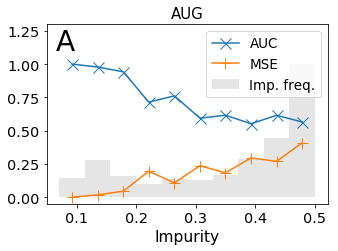

In [57]:
fig, ax = plt.subplots(1,1,  figsize=(4 * 1.2, 3 * 1.2))
break_point_entropy_test, break_point_gini_test = af.plot_breakpoint(prediction_from_test_hpo,
                                                                     labelsize=14.5,
                                                                     ax=ax, colors='tab:grey')
ax.set_title(response_name, size=15);

ax.text(0.1, 0.9, subplotlabel(response_name), fontsize=28,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

fig.tight_layout()

# fig.savefig(folder + 'impurity_plot_test.png')

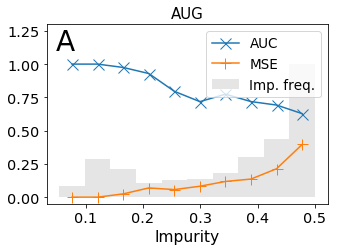

In [58]:
prediction_from_train_hpo = af.get_prediction(clf_hpo, X_train, y_train)
fig, ax = plt.subplots(1,1,  figsize=(4 * 1.2,
                                      3 * 1.2))
break_point_entropy_train, break_point_gini_train = af.plot_breakpoint(prediction_from_train_hpo,
                                                                       labelsize=14.5,
                                                                       ax=ax, colors='tab:grey')
ax.set_title(response_name, size=15);
ax.text(0.1, 0.9, subplotlabel(response_name), fontsize=28,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

fig.tight_layout()

# fig.savefig(folder + 'impurity_plot_train.png')

## Drop the factors corresponding to current admission

In [59]:
to_nan = ['ABX_CTX', 'ABX_AK', 'ABX_CIP', 'ABX_TAZ', 'ABX_ATM',
           'ABX_GT', 'ABX_TEM', 'ABX_AUG', 'ABX_CAZ', 'ABX_MEM','ABX_ETP', 'R_b72', 'n_days']
X_test_b48 = X_test.copy()
X_train_b48 = X_train.copy()
for i in to_nan:
    X_test_b48.loc[:,i] = np.nan
    X_train_b48.loc[:,i] = np.nan


prediction_from_test_b48 = af.get_prediction(clf_hpo, X_test_b48, y_test)

_ = ab.bootstrapped_auc(prediction_from_test_b48['true response'], prediction_from_test_b48['p'], size=100)
print("%.2f (95%% CI %.2f-%.2f)"%(_[1], _[0],_[2]))

to_nan = ['ABX_CTX', 'ABX_AK', 'ABX_CIP', 'ABX_TAZ', 'ABX_ATM',
          'ABX_GT', 'ABX_TEM', 'ABX_AUG', 'ABX_CAZ', 'R_b72',
          'ABX_b72_CTX', 'ABX_b72_AK',
          'ABX_b72_CIP', 'ABX_b72_TAZ', 'ABX_b72_ATM', 'ABX_b72_GT',
          'ABX_b72_TEM', 'ABX_b72_AUG', 'ABX_b72_CAZ', 'ABX_b72_CAZ',
          'n_days']
X_test_b48 = X_test.copy()
for i in to_nan:
    X_test_b48.loc[:,i] = np.nan 
    
prediction_from_test_b48 = af.get_prediction(clf_hpo, X_test_b48, y_test)
prediction_from_train_b48 = af.get_prediction(clf_hpo, X_train_b48, y_train)

_ = ab.bootstrapped_auc(prediction_from_test_b48['true response'], prediction_from_test_b48['p'], size=500)
print("%.2f (95%% CI %.2f-%.2f)"%(_[1], _[0],_[2]))

0.78 (95% CI 0.75-0.80)
0.77 (95% CI 0.74-0.80)


In [61]:
print("Comparison between true response and prescription in all data.\n")
idx_1 = X_test['ABX_' + response_name].reset_index(drop=True).astype(bool)
idx_2 = X_train['ABX_' + response_name].reset_index(drop=True).astype(bool)
is_prescribed = pd.concat([idx_1,idx_2]).reset_index(drop=True)
is_prescribed.name = response_name + ' is prescr.'

print("The percentage of admission which had %s given is %.0f%% (%d of %d)."%(response_name,
                                                                                np.mean(is_prescribed)*100,
                                                                                np.sum(is_prescribed),
                                                                                len(is_prescribed)))
prediction_from_all_b48 = pd.concat([prediction_from_test_b48, prediction_from_train_b48]).reset_index(drop=True)
n_matches = np.sum(~prediction_from_all_b48.loc[is_prescribed,'true response'].astype(bool) )
print("The number of matches were: %s"%(n_matches))

n_mismatches = np.sum(prediction_from_all_b48.loc[is_prescribed,'true response'].astype(bool) )
print("The number of mismatches were: %s"%(n_mismatches))


from IPython.display import display

display(
    pd.crosstab(is_prescribed,  prediction_from_all_b48['true response'].rename('Res. to ' + response_name).astype(bool))
)


print("Of those, %d admissions had %s-resistant isolates. These admissions can be thought of as the no. of mismatches " \
      "or the no. false negatives of the doctor prediction (the doctor only prescribes an antibiotics if they predict "\
      " susceptibility)."%(n_mismatches, response_name))
CI = af.binom_test(n_mismatches, np.sum(is_prescribed))
print("Percentage: %.0f%% (%d of %d) (CIs %.0f%%--%.0f%%).\n"%(n_mismatches / np.sum(is_prescribed) * 100,
                                                                      n_mismatches,
                                                                      np.sum(is_prescribed),
                                                                      CI[0] * 100, CI[1] * 100,))

print("To allow fair comparison with GBDT results, we imagine to treat inpatients as follows.")

# number of inpatience who had AMR
n_true_response = np.sum(prediction_from_all_b48['true response'])

print("1) We first set negative-to-%s-resistance the %d admissions with the lowest probability of AMR,"%(response_name,
                                                                                                n_true_response))
print("where %d is the true number of AMR cases in the test set--"%(n_true_response))
print("thus maintaining the population-level percentage of %.0f%% of AMR to %s."%(np.mean(prediction_from_all_b48['true response']) * 100,
                                                                                  response_name))

# take the n_true_response inpatients who had the highest prob of resistance
predicted_response = prediction_from_all_b48['p'].rank(ascending=False) <= n_true_response

# take the admissions that are predicted Susceptible (lowest prob of AMR) and had prescription (Series is_prescribed).
idx_ = (~predicted_response) & is_prescribed
print("2) Then we imagine to give %s-treatment only to those %d inpatients that both are actually"\
      " treated with %s *and* are predicted susceptible (n of matches)."%(response_name, np.sum(idx_), response_name))
print("3) Finally, among these, we check the number of false negatives of the GBDT prediction, as the number of mismatches.")
mism = prediction_from_all_b48.loc[idx_, 'true response'].astype(bool) #& ~prediction_from_test_b48.loc[idx,'predicted response 2'].astype(bool)
CI = af.binom_test(np.sum(mism), np.sum(idx_) )
print("Only %d admissions had %s-resistant isolates."%(np.sum(mism), response_name))
print("Percentage: %.0f%% (%d over %d) (CIs %.0f%%--%.0f%%).\n"%(np.sum(mism) / np.sum(idx_) * 100,
                                                                  np.sum(mism),
                                                                  np.sum(idx_),
                                                                  CI[0] * 100, CI[1] * 100,))

print("The number of matches with this strategy is %d.\n\n"%(
    np.sum(
        (~prediction_from_all_b48.loc[:, 'true response'].astype(bool)) & idx_)))

print("As less conservative strategy, let us start from the number of matches. We administer "
"%s to inpatients starting from the one with the lowest probability of AMR to the one the highest probability of AMR."%(response_name))
print("(provided that %s has been also prescribed during the true admission)"%(response_name))
print("until the number of matches is %s."%(n_matches))

n = 0; i = 0
order = prediction_from_all_b48['p'].sort_values().index
predicted_response2 = ~np.zeros(prediction_from_all_b48.shape[0]).astype(bool)
simulated_prescription = np.zeros(prediction_from_all_b48.shape[0]).astype(bool)
while n < n_matches:
    index = order[i]
    i = i + 1
    # set to AMR predicted:
    predicted_response2[index] = False
    
    ## if the ABX has been acually prescribed
    if is_prescribed.iloc[index]:
        # then prescribe in simulation as well
        simulated_prescription[index] = True
        
        # if is match (true outcome is not R)
        if ~prediction_from_all_b48['true response'].iloc[index].astype(bool):
            n = n + 1

print("As in earlier point 2) we imagined to give %s-treatment only to those %d inpatients that both are actually treated"\
      " with %s *and* are predicted susceptible."%(response_name,
                                                   np.sum(~predicted_response2 * simulated_prescription),
                                                   response_name))
print("Sanity check: these number must be %d < %d."%(n, np.sum(simulated_prescription)))

print("3) Finally, among these, we check the number of false negatives of the GBDT prediction (number of mismatches of this strategy).")

mism = prediction_from_all_b48.loc[simulated_prescription, 'true response'].astype(bool) 
CI = af.binom_test(np.sum(mism), np.sum(simulated_prescription) )
print("Only %d admissions had %s-resistant isolates."%(np.sum(mism), response_name))
print("Percentage: %.0f%% (%d over %d) (CIs %.0f%%--%.0f%%).\n"%(np.sum(mism) / np.sum(simulated_prescription) * 100,
                                                                  np.sum(mism),
                                                                  np.sum(simulated_prescription),
                                                                  CI[0] * 100, CI[1] * 100,))


print("The number of matches with this strategy is %d."%(
    np.sum(
        (~prediction_from_all_b48.loc[:, 'true response'].astype(bool)) & simulated_prescription)))

Comparison between true response and prescription in all data.

The percentage of admission which had AUG given is 47% (1864 of 3984).
The number of matches were: 1233
The number of mismatches were: 631


Res. to AUG,False,True
AUG is prescr.,,
False,1296,824
True,1233,631


Of those, 631 admissions had AUG-resistant isolates. These admissions can be thought of as the no. of mismatches or the no. false negatives of the doctor prediction (the doctor only prescribes an antibiotics if they predict  susceptibility).
Percentage: 34% (631 of 1864) (CIs 32%--36%).

To allow fair comparison with GBDT results, we imagine to treat inpatients as follows.
1) We first set negative-to-AUG-resistance the 1455 admissions with the lowest probability of AMR,
where 1455 is the true number of AMR cases in the test set--
thus maintaining the population-level percentage of 37% of AMR to AUG.
2) Then we imagine to give AUG-treatment only to those 1226 inpatients that both are actually treated with AUG *and* are predicted susceptible (n of matches).
3) Finally, among these, we check the number of false negatives of the GBDT prediction, as the number of mismatches.
Only 210 admissions had AUG-resistant isolates.
Percentage: 17% (210 over 1226) (CIs 15%--19%).

The number of matche

----------------------

There are a number of goodness-of-prediction metrics. We first consider the so-called
*accuracy score*, the *balanced accuracy score*, and the *mean squared error*.
Standard practise is to compute the  goodness of prediction over all the entries, regardless of their entropy. 

In [62]:
af.Goodness_of_prediction(prediction_from_test_hpo, clf_hpo, break_point_entropy_test)

accuracy score		0.745
balanced accur. score	0.671
mean squared error	0.255

The goodness of prediction for the low-impurity group is:
 accuracy score		0.940
 balanced accur. score	0.902
 mean squared error	0.060

The goodness of prediction for the high-impurity group is:
 accuracy score		0.664
 balanced accur. score	0.592
 mean squared error	0.336


,all,low,high
0,0.745,0.940,0.664
1,0.671,0.902,0.592
2,0.255,0.060,0.336


Not bad. The prediction for the **low-entropy** group is substantially better.


Another way to assess goodness-of-prediction is the receiver operating characteristic (ROC) curve (95% CI low - upp):

all 0.78 0.75 0.81
low entropy group 0.95 0.92 0.97
high entropy group 0.65 0.61 0.69


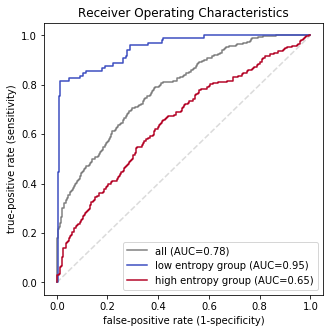

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
af.plot_ROC_entropy(prediction_from_test_hpo, clf_hpo, break_point_entropy_test, ax=ax, CI=True)
# fig.savefig(folder + 'ROC_good_classifier.png')

In [64]:
# from sklearn.metrics import roc_curve
# x,y,_=roc_curve(prediction_from_test_hpo['true response'], prediction_from_test_hpo['p'])
# pd.DataFrame({'x':x, 'y':y}).to_csv(folder + '_ROC.csv')
# plt.plot(x,y)

#  Feature importance 

Here we assess the importance for classification of each feature in the dataset by means of the so-called "Shapley values".

For a given database entry $i$ (say, a hospital episode), some feature values have a large impact on the prediction $P_R(i)$, whereas others have a small impact. The Shapley values $\phi_j(P_R)$, $j=1,\ldots, M$ are a unique allocation of credit among the $M$ features $j$ for each database entry, which has certain desirable properties -- is accurate and consistent -- Slundberg & Lee (2012)).

In our case, the classifier is gradient-boosting model with so-called "Softmax" objective function, and the Shapley values obey 
$$
\mathrm{softmax}^{-1} P_R = \sum_{j=1}^{M} \phi_j(P_R) + \phi_0(P_R),
$$
where $\phi_0(P_R)$ is the expected value $E[\mathrm{softmax}^{-1} P_R]$ of the model prediction over the entries.


In [65]:
shap_values_test = shap.TreeExplainer(clf_hpo.bst).shap_values(X_test)
shap_values_train = shap.TreeExplainer(clf_hpo.bst).shap_values(X_train)

Print feature importance of each feature. For tree models, importance is usually defined  as:
 * ‘weight’: the number of times a feature is used to split the data across all trees (default)
 * ‘gain’: the average gain across all splits the feature is used in.
 * ‘cover’: the average coverage across all splits the feature is used in.
 * ‘total_gain’: the total gain across all splits the feature is used in.
 * ‘total_cover’: the total coverage across all splits the feature is used in.

In [66]:
for importance_type in ['cover', 'gain']:#, 'total_cover', 'total_gain']:
    scores = dict(sorted(clf_hpo.bst.get_score(importance_type=importance_type).items(), key=lambda x: -x[1]))
    tmp = []
    for k in scores:
        tmp.append(scores[k])
    print("\nThe most important features for " + "%s"%(importance_type) + " importance are:")
#     print(np.quantile(tmp, 0.75))
    for k in scores:
        if scores[k] > np.quantile(tmp, 0.90):
            print("%.2f & %s \\\\"%(scores[k], st.code_to_diagnosis(k)))


The most important features for cover importance are:
463.43 & resistance to AUG previously found \\
388.27 & CTX previously prescribed \\
371.00 & CONSPEF TRAUMA & ORTHOPAEDICS \\
357.09 & diagnosis: Coronary diseases \\
342.98 & ORG KPNE \\
335.18 & resistance to TAZ previously found \\
331.18 & admim. Other emergency \\

The most important features for gain importance are:
58.64 & resistance to AUG previously found \\
20.90 & susceptibility to AUG previously found \\
10.65 & susceptibility to CIP previously found \\
9.45 & susceptibility to ETP previously found \\
9.11 & susceptibility to GT previously found \\
8.86 & M \\
8.75 & diagnosis: Hypertension \\


In [67]:
shap_values = shap_values_train

In [68]:
importance = np.mean(np.abs(shap_values), axis=0)
#shap_values.mean(axis=0)
idx = np.argsort(importance)[-1:0:-1]
print("The most important features by sum of their effect are:")
for i in range(10):
    if importance[idx][i] > np.quantile(importance, 0.90):
        print("%.2f & %s \\\\"%(importance[idx][i], st.code_to_diagnosis(X_train.columns.values[idx][i])))

The most important features by sum of their effect are:
0.63 & susceptibility to AUG previously found \\
0.40 & resistance to AUG previously found \\
0.15 & ADMIDATE \\
0.14 & AUG previously prescribed \\
0.13 & ORG KPNE \\
0.11 & susceptibility to CIP previously found \\
0.10 & total days in hospitals \\
0.09 & resistance to any previously found \\
0.08 & Early test \\
0.08 & susceptibility to ETP previously found \\


In [69]:
['cover', 'gain']
importances_cover = {
    'key':list(clf_hpo.bst.get_score(importance_type='cover').keys()),
    'Cover':list(clf_hpo.bst.get_score(importance_type='cover').values())}
importances_gain = {
    'key':list(clf_hpo.bst.get_score(importance_type='gain').keys()),
    'Gain':list(clf_hpo.bst.get_score(importance_type='gain').values())}
importances_cover = pd.DataFrame(importances_cover)
importances_gain = pd.DataFrame(importances_gain)

#
importances_sigma = {
    'key':list(X_train.columns.values),
    '$\Sigma$':list(np.mean(np.abs(shap_values), axis=0))}
importances_sigma = pd.DataFrame(importances_sigma)


tmp = ssp.rank_shap(shap_values, X_train.values, None, onlyrank=False)
importances_I = {
    'key':list(X_train.columns.values),
    'I':list(tmp[1]),
    'low': list( tmp[1] - 1.96 * tmp[2]),
    'upp': list( tmp[1] + 1.96 * tmp[2])
}

Importances_OR = af.ORs(X_train, y_train)
importances_I = pd.DataFrame(importances_I)
importances = importances_cover.merge(importances_gain, on='key').merge(importances_sigma, on='key')
importances_I = importances_I.merge(importances, on='key').merge(Importances_OR, on='key')

from scipy.stats.stats import pearsonr

print("%.1f %.e"%pearsonr(importances_I['Gain'], importances_I['$\Sigma$']))

Q = np.quantile(importances_I['$\Sigma$'], 0.75)
print("\n r|l|cc|cc|cc")
print("Outcome & Factor & $\Sigma$ & Gain & I & 95\% CI & OR & 95\% CI \\\\ ")
print("\hline")
print("\hline")
for idx, row in importances_I.sort_values(by='$\Sigma$', ascending=False).iterrows():
    if row['$\Sigma$'] > Q:
        print("& %s & $%.2f$ & $%.2f$ & $%.2f$  & $%.2f,%.2f$ & $%.2f$  & $%.2f,%.2f$\\\\"%(st.code_to_diagnosis(row['key'])[:25],
                                              row['$\Sigma$'],
                                              row['Gain'],
                                              row['I'], row['low'], row['upp'],
                                              row['logOR'], row['lowOR'], row['uppOR']))        
print("\hline")


0.7 6e-11

 r|l|cc|cc|cc
Outcome & Factor & $\Sigma$ & Gain & I & 95\% CI & OR & 95\% CI \\ 
\hline
\hline
& susceptibility to AUG pre & $0.63$ & $20.90$ & $-0.46$  & $-0.47,-0.44$ & $nan$  & $nan,nan$\\
& resistance to AUG previou & $0.40$ & $58.64$ & $0.58$  & $0.56,0.60$ & $nan$  & $nan,nan$\\
& ADMIDATE & $0.15$ & $6.53$ & $-0.00$  & $-0.00,-0.00$ & $nan$  & $nan,nan$\\
& AUG previously prescribed & $0.14$ & $8.65$ & $0.18$  & $0.17,0.19$ & $0.46$  & $0.31,0.62$\\
& ORG KPNE & $0.13$ & $8.31$ & $-0.62$  & $-0.62,-0.61$ & $-0.94$  & $-1.22,-0.66$\\
& susceptibility to CIP pre & $0.11$ & $10.65$ & $0.07$  & $0.06,0.07$ & $nan$  & $nan,nan$\\
& total days in hospitals & $0.10$ & $7.04$ & $0.00$  & $0.00,0.00$ & $nan$  & $nan,nan$\\
& resistance to any previou & $0.09$ & $8.74$ & $0.26$  & $0.25,0.26$ & $0.77$  & $0.60,0.95$\\
& Early test & $0.08$ & $6.34$ & $-0.14$  & $-0.14,-0.14$ & $-0.31$  & $-0.47,-0.15$\\
& susceptibility to ETP pre & $0.08$ & $9.45$ & $0.04$  & $0.03,0.04$ & $n

In [70]:
idx = ~np.isnan(importances_I['logOR'])
print(
    "%.1f %e"%pearsonr(importances_I.loc[idx,'logOR'], importances_I.loc[idx,'I']))

0.9 1.040928e-17


## Importance of comorbidities

In [71]:
def aster(string):
    return ''

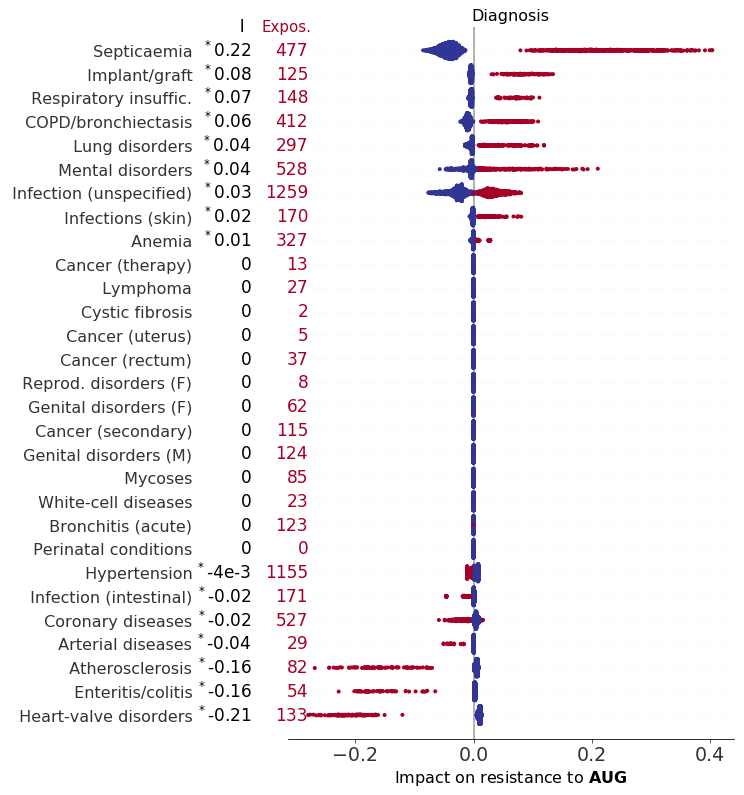

In [72]:
index_SDG = [i  for i,k in enumerate(X_train.columns.values) if k in set(comorbitities_features)]
feature_names=st.vcode_to_diagnosis_v(X_train.columns.values[index_SDG])
feature_names = ["Cystic fibrosis"   if f == 'has fibrosis' else f[10:] for f in feature_names]
ssp.summary_plot(shap_values[:,index_SDG],
                  X_train.iloc[:,index_SDG], max_display=307,  cmap=cm.get_cmap('RdYlBu_r'), show=False,
                  feature_names=feature_names,  I=True,fontsize=16,
                  color_bar=False, sort=True, scale_=0.01, exposure=True)

fig = plt.gcf()
plt.title("Diagnosis", size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.savefig(folder + 'shap_comorbidities.png', bbox_inches='tight')
plt.show()

These features are binary, so red corresponds to 1, blue corresponds to 0.

## Importance of CONSPEF features

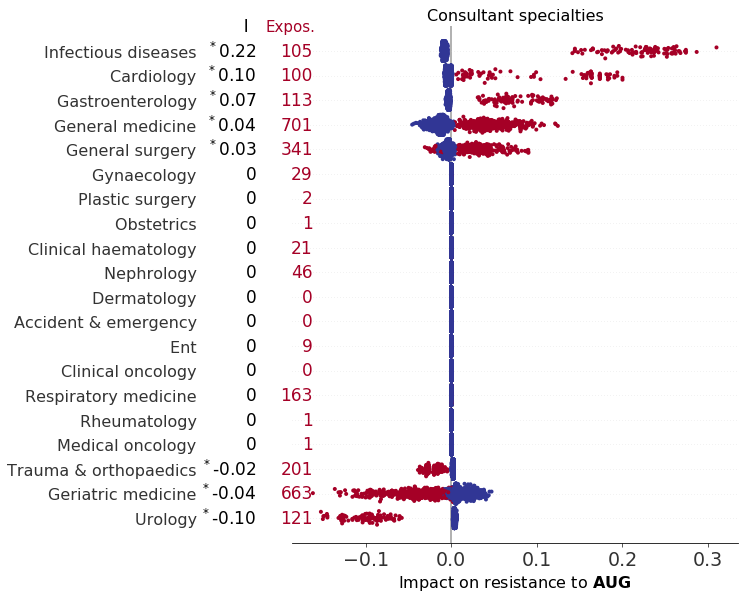

In [74]:
index_CONSPEF = [i for i,k in enumerate(X_train.columns.values) if k in set(consultant_features)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_CONSPEF])
feature_names = [name[8:] for name in feature_names]
feature_names = [_.lower().capitalize() for _ in feature_names]
# feature_names = [aster(name) + name[len("CONSPEF "):] for name in feature_names]
ssp.summary_plot(shap_values[:, index_CONSPEF], \
                 X_train.iloc[:,index_CONSPEF], max_display=len(index_CONSPEF), cmap=cm.get_cmap('RdYlBu_r'),
                 feature_names=feature_names, show=False, I=True, exposure=True,fontsize=16,
                 color_bar=False)
fig = plt.gcf()
plt.title('Consultant specialties', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.tight_layout()
fig.savefig(folder + 'shap_CONSPEF.png', bbox_inches='tight')
plt.show()

## Importance of ADMIMETH

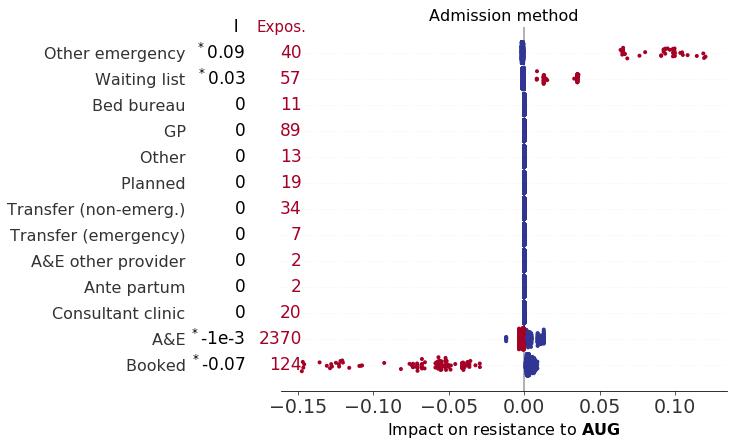

In [75]:
index_ADMI = [i  for i,k in enumerate(X_train.columns.values) if k in set(admission_features)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ADMI])
feature_names = [name[7:] for name in feature_names]
ssp.summary_plot(shap_values[:, index_ADMI], \
                  X_train.iloc[:,index_ADMI], max_display=len(index_ADMI), feature_names=feature_names,
                  cmap=cm.get_cmap('RdYlBu_r'), show=False, I=True, exposure=True,fontsize=16,
                  color_bar=False)
fig = plt.gcf()
plt.title('Admission method', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.savefig(folder + 'shap_ADMIMETH.png', bbox_inches='tight')
plt.show()

## Importance of the ABX features.

In [76]:
O = ['AUG', 'CIP', 'MEM', 'TAZ', 'AK', 'ATM', 'CAZ', 'CTX', 'ETP', 'GT','TEM']
my_order = dict(zip(O, range(len(O))))

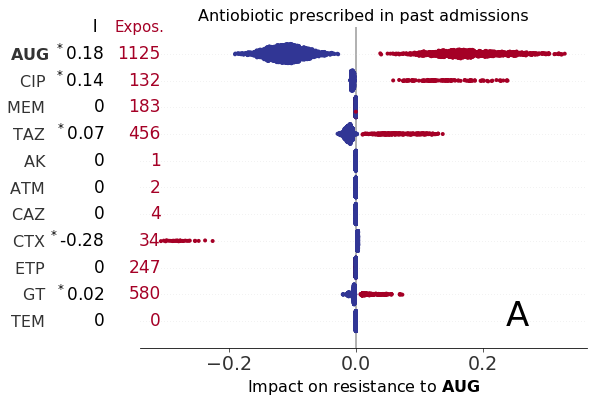

In [83]:
index_ABX = [i  for i,k in enumerate(X_train.columns.values) if k in set(ABX_features_1)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ABX])
feature_names = [x.split(' ')[0] for x in feature_names]
odx = np.argsort([my_order[x] for x in feature_names])
feature_names = [r'$\mathbf{'+x+'}$' if x==response_name else x for x in np.array(feature_names)[odx]]
# feature_names = [aster(name) + name[len("admim. "):] for name in feature_names]
ssp.summary_plot(shap_values[:, index_ABX][:, odx], \
                 X_train.iloc[:,index_ABX].values[:, odx],
                 max_display=len(index_ABX), feature_names=feature_names, sort=False,
                 cmap=cm.get_cmap('RdYlBu_r'), show=False, exposure=True, I=True, scale_=0.01,
                 color_bar=False, fontsize=16)
fig = plt.gcf()

fig.gca().text(0.8, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=fig.transFigure)

plt.title('Antiobiotic prescribed in past admissions', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.savefig(folder + 'shap_previous_prescriptions.png', bbox_inches='tight')
plt.show()


In [84]:
cm1 = cm.get_cmap('RdYlBu_r')
colori = cm1(np.hstack([[0],np.linspace(0.5,1,256)]))
cm2=colors.ListedColormap(colori)

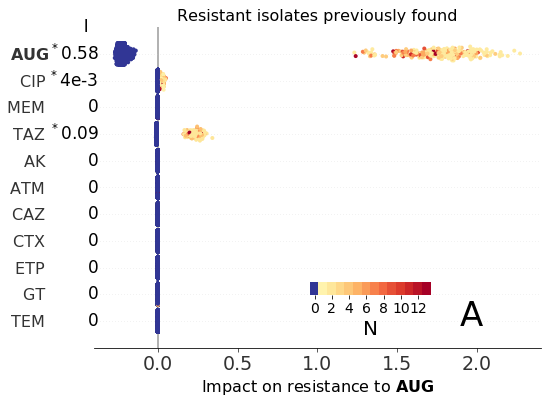

In [86]:
index_ABX = [i  for i,k in enumerate(X_train.columns.values) if k in set(ABX_features_2)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ABX])
feature_names = [x.split(' ')[2] for x in feature_names]
odx = np.argsort([my_order[x] for x in feature_names])
feature_names = [r'$\mathbf{'+x+'}$' if x==response_name else x for x in np.array(feature_names)[odx]]

ssp.summary_plot(shap_values[:, index_ABX][:,odx], \
                  X_train.iloc[:,index_ABX].values[:,odx], max_display=len(index_ABX), feature_names=feature_names,
                  cmap=cm2, show=False, I=True, sort=False,fontsize=16,
                  color_bar=False)
fig = plt.gcf()

fig.gca().text(0.8, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=fig.transFigure)

plt.title('Resistant isolates previously found', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
m = cm.ScalarMappable(cm2)
m.set_array([0, 1])        
N =  len(np.unique(X_train.iloc[:,index_ABX].values))
bounds = np.linspace(0,N,N+1) - 0.5
norm = colors.BoundaryNorm(bounds, cm2.N)
fig = plt.gcf()
ax1 = plt.gca()
ax2 = fig.add_axes([0.5, 0.25, 0.21, 0.03])
m = cm.ScalarMappable(norm, cm2)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=np.arange(0,N+1,2), ax=ax1, cax=ax2, orientation='horizontal', drawedges=False)
cb.outline.set_visible(False)
cb.ax.set_xlabel('N',size=20)
for t in cb.ax.get_xticklabels():
     t.set_fontsize(14)
        
# fig.savefig(folder + 'shap_previous_tests_R.png', bbox_inches='tight')
plt.show()

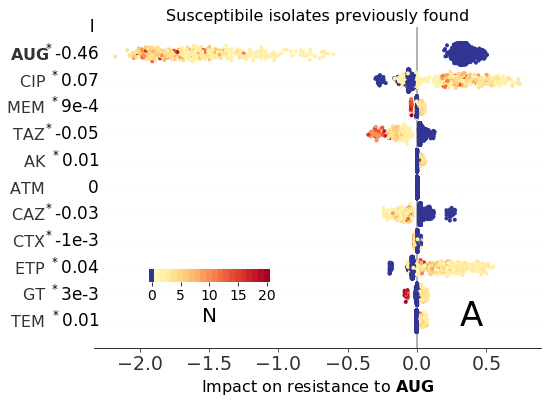

In [87]:
index_ABX = [i  for i,k in enumerate(X_train.columns.values) if k in set(ABX_features_3)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ABX])
feature_names = [x.split(' ')[2] for x in feature_names]
odx = np.argsort([my_order[x] for x in feature_names])
feature_names = [r'$\mathbf{'+x+'}$' if x==response_name else x for x in np.array(feature_names)[odx]]

ssp.summary_plot(shap_values[:, index_ABX][:,odx], \
                  X_train.iloc[:,index_ABX].values[:,odx], max_display=len(index_ABX), feature_names=feature_names,
                  cmap=cm2,  show=False, I=True, sort=False,fontsize=16,
                  color_bar=False)
fig = plt.gcf()


fig.gca().text(0.8, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=fig.transFigure)

plt.title('Susceptibile isolates previously found', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')

m = cm.ScalarMappable(cm2)
m.set_array([0, 1])        
N =  len(np.unique(X_train.iloc[:,index_ABX].values))
bounds = np.linspace(0,N,N+1) - 0.5
norm = colors.BoundaryNorm(bounds, cm2.N)
fig = plt.gcf()
ax1 = plt.gca()
ax2 = fig.add_axes([0.22, 0.28, 0.21, 0.03])
m = cm.ScalarMappable(norm, cm2)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=np.arange(0,N+1,5), ax=ax1, cax=ax2, orientation='horizontal', drawedges=False)
cb.outline.set_visible(False)
cb.ax.set_xlabel('N',size=20)
for t in cb.ax.get_xticklabels():
     t.set_fontsize(14)

# fig.savefig(folder + 'shap_previous_tests_S.png', bbox_inches='tight')
plt.show()

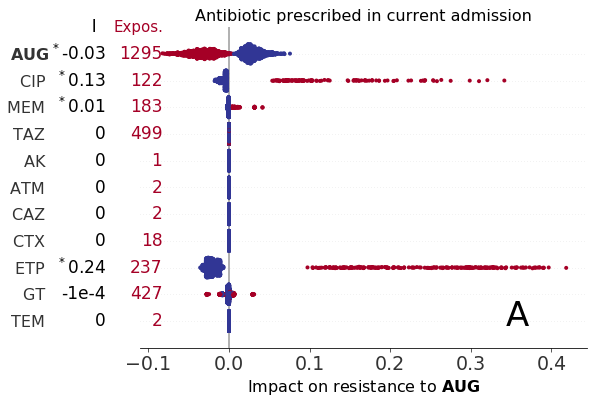

In [88]:
index_ABX = [i  for i,k in enumerate(X_train.columns.values) if k in set(ABX_features_4)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ABX])
feature_names = [x.split(' ')[1] for x in feature_names]
odx = np.argsort([my_order[x] for x in feature_names])
feature_names = [r'$\mathbf{'+x+'}$' if x==response_name else x for x in np.array(feature_names)[odx]]
ssp.summary_plot(shap_values[:, index_ABX][:, odx], \
                 X_train.iloc[:,index_ABX].values[:, odx],
                 max_display=len(index_ABX), feature_names=feature_names, sort=False,
                 cmap=cm.get_cmap('RdYlBu_r'), show=False, exposure=True, I=True, scale_=0.01,
                 color_bar=False, fontsize=16)


fig = plt.gcf()

fig.gca().text(0.8, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=fig.transFigure)

plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
plt.title('Antibiotic prescribed in current admission', size=16)
# fig.savefig(folder + 'shap_current_treatment.png', bbox_inches='tight')
plt.show()

In [90]:
B = ['ECOL', 'KPNE', 'PAER']
B_order = dict(zip(B, range(len(B))))

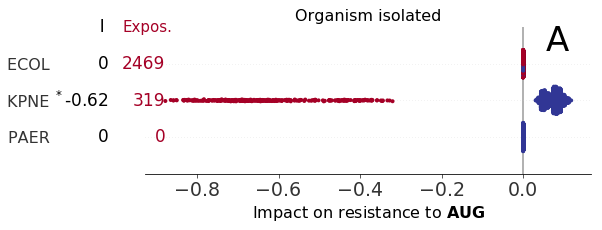

In [91]:
index_ABX = [i  for i,k in enumerate(X_train.columns.values) if k in set(organism_features)]
from matplotlib import rc,cm
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_ABX])
feature_names = [x.split(' ')[1] for x in feature_names]
bdx = [B_order[x] for x in feature_names]
ssp.summary_plot(shap_values[:, index_ABX][:,bdx],
                 X_train.iloc[:,index_ABX].values[:,bdx], max_display=len(index_ABX),
                 feature_names=np.array(feature_names)[bdx],fontsize=16,
                 cmap=cm.get_cmap('RdYlBu_r'),  show=False, exposure=True, scale_=0.01, I=True, sort=False,
                 color_bar=False)
fig = plt.gcf()
# fig.tight_layout()
ax= fig.gca()
plt.title('Organism isolated', size=16)
plt.text(0.95, 0.9, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.savefig(folder + 'shap_organism.png', bbox_inches='tight')
plt.show()

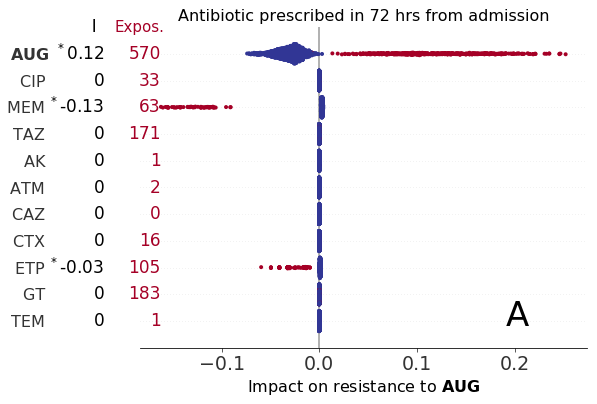

In [92]:
index = [i  for i,k in enumerate(X_train.columns.values) if k in set(early_prescription_features)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index])
feature_names = [x.split(' ')[0] for x in feature_names]
odx = np.argsort([my_order[x] for x in feature_names])
feature_names = [r'$\mathbf{'+x+'}$' if x==response_name else x for x in np.array(feature_names)[odx]]
ssp.summary_plot(shap_values[:, index][:,odx], \
                  X_train.iloc[:,index].values[:,odx], max_display=len(index), feature_names=feature_names, 
                  cmap=cm.get_cmap('RdYlBu_r'),  show=False, scale_=0.01, exposure=True, I=True, sort=False,fontsize=16,
                  color_bar=False)
fig = plt.gcf()

fig.gca().text(0.8, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=fig.transFigure)

plt.title('Antibiotic prescribed in 72 hrs from admission', size=16)
plt.xlabel('Impact on resistance to ' +  r'$\mathbf{' + response_name + '}$')
# fig.savefig(folder + 'shap_early_prescription.png', bbox_inches='tight')
plt.show()

## Importance of the remaining features.

The remaining features are demographic and laboratory-test results.
There are continuous variables here, so there are color shades.

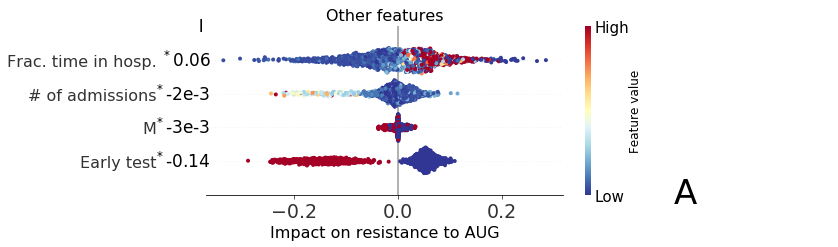

Exposure of sex male and early testing: 1008, 957


In [93]:
# ['fraction_days_in_hospitals', 'number_of_hospital_visits', 'is_M', 'R_b72']
ff = ['ADMIDATE', 'n_days', 'n_comorb', 'total_days_in_hospitals', 'age']
index_others = [i for i,k in enumerate(X_train.columns.values) \
                if k not in set(ff) | set(comorbitities_features) | set(consultant_features) | set(admission_features) | set(ABX_features) | set(organism_features) | set(early_prescription_features)]
feature_names = st.vcode_to_diagnosis_v(X_train.columns.values[index_others])
ssp.summary_plot(shap_values[:, index_others], \
                 X_train.iloc[:,index_others], max_display=len(index_others),
                 feature_names=feature_names,  show=False, I=True,
                 cmap=cm.get_cmap('RdYlBu_r'), scale_=0.03, sort=False,fontsize=16,
                 color_bar=True)
fig = plt.gcf()
# fig.tight_layout()
plt.title('Other features', size=16)
plt.text(1.4, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)


plt.xlabel('Impact on resistance to ' + response_name)
fig.savefig(folder + 'shap_other.png', bbox_inches='tight')
plt.show()

print("Exposure of sex male and early testing: %d, %d"%(np.sum(X_train.iloc[:,index_others].iloc[:,2]), np.sum(X_train.iloc[:,index_others].iloc[:,3])))

### Partial dependence plots

In [94]:
idx_match = X_train['is_M'].astype(bool)

for F in [f for f in X_train.columns.values[index_others] if f in ['age']]:
    print(F, "(", st.code_to_diagnosis(F), ")")
    fig, ax = plt.subplots(1, 2, figsize=(6*2, 5))
    color = ['tab:blue' if b else 'tab:red' for b in idx_match.values]
    ssp.my_dependence_plot(F, shap_values[~idx_match.values,:], X_train.loc[~idx_match.values,:], ax=ax[0], color='tab:red',
                           alpha=0.5, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)
        
    ssp.my_dependence_plot(F, shap_values[idx_match.values,:], X_train.loc[idx_match.values,:], ax=ax[1], color='tab:blue',
                           alpha=0.5, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)

    ax[0].set_autoscale_on(False)

    plt.show()
    fig.tight_layout()
#     fig.savefig(folder + 'dependence_plot_' + F + '.png')

ADMIDATE ( ADMIDATE )


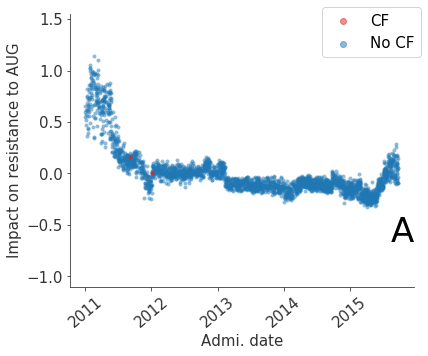

age ( age )


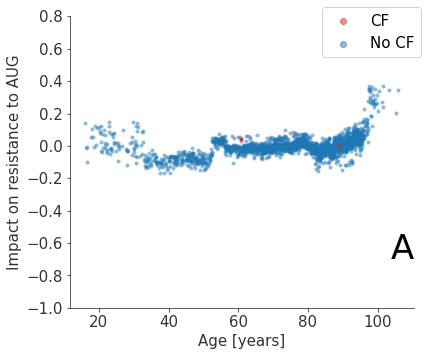

n_comorb ( No. como. )


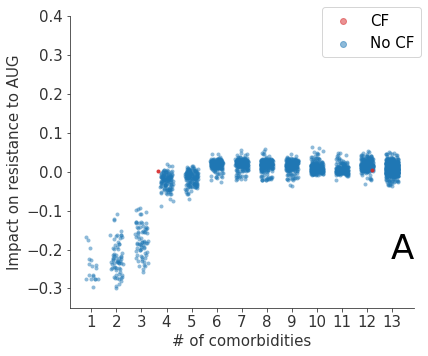

In [95]:
features = ['ADMIDATE', 'age', 'n_comorb']
features_names = ['Admi. date', 'Age [years]', '# of comorbidities']

idx_match = ~has_fibrosis_train
from matplotlib.ticker import FormatStrFormatter

index_others = [i for i,k in enumerate(X_train.columns.values) \
                if k not in set(comorbitities_features) | set(consultant_features) | set(admission_features) | set(ABX_features) | set(organism_features) | set(early_prescription_features)]

for i,F in enumerate([f for f in X_train.columns.values[index_others] if f in features]):
    print(F, "(", st.code_to_diagnosis(F), ")")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    color = ['tab:blue' if b else 'tab:red' for b in idx_match.values]
    ssp.my_dependence_plot(F, shap_values[idx_match.values,:], X_train.loc[idx_match.values,:], ax=ax, color='tab:blue',
                           alpha=0.5, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)
    ssp.my_dependence_plot(F, shap_values[~idx_match.values,:], X_train.loc[~idx_match.values,:], ax=ax, color='tab:red',
                           alpha=0.9, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)
    ax.set_autoscale_on(False)
    ax.scatter([-10000,10001],[-1,1], color='tab:red', alpha=0.5, label='CF')
    ax.scatter([-10000,10001],[-1,1], color='tab:blue', alpha=0.5, label="No CF")

    fig.legend(fontsize=15)
    if i == 2:
        I = X_train.columns.values == F
        n_max = np.nanmax(X_train.loc[:,I])
        ax.set_xticks(range(1,n_max+1))
        ax.set_ylim([-0.35, 0.4])
        
    
    if i == 0:
        I = X_train.columns.values == F
        xlabels = pd.Series(np.r_[0:2500:365])
        dates = st.int2date(xlabels, '2010-01-02')
        ax.set_ylim([-1.1, 1.55])
        ax.set_xticklabels(dates.dt.year)
        ax.tick_params(axis='x', rotation=40)
        
    if i == 1:
        ax.set_ylim([-1,0.8])
            
    ax.set_ylabel("Impact on resistance to " + response_name, fontsize=15)
    ax.set_xlabel(features_names[i], fontsize=15)    
    ax.tick_params(labelsize=15)
    fig.tight_layout()
    
    plt.text(1, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

    plt.show()
    fig.savefig(folder + 'dependence_plot_' + F + '.png')


n_days ( number of days )


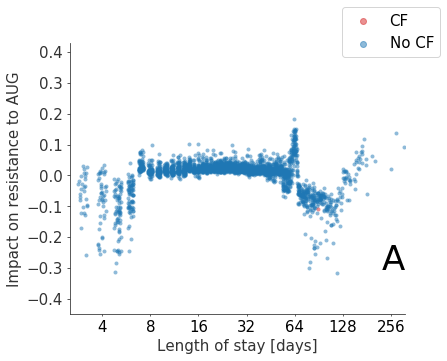

total_days_in_hospitals ( total days in hospitals )


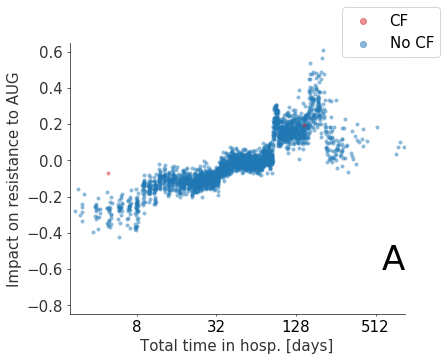

In [96]:
features = ['n_days', 'total_days_in_hospitals']
features_names = ['Length of stay [days]', 'Total time in hosp. [days]']

idx_match = ~has_fibrosis_train
from matplotlib.ticker import FormatStrFormatter

for i,F in enumerate([f for f in X_train.columns.values[index_others] if f in features]):
    print(F, "(", st.code_to_diagnosis(F), ")")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    color = ['tab:blue' if b else 'tab:red' for b in idx_match.values]
    ssp.my_dependence_plot(F, shap_values[idx_match.values,:], X_train.loc[idx_match.values,:], ax=ax, color='tab:blue',
                           alpha=0.5, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)
    ssp.my_dependence_plot(F, shap_values[~idx_match.values,:], X_train.loc[~idx_match.values,:], ax=ax, color='tab:red',
                           alpha=0.5, feature_name = st.code_to_diagnosis(F), x_jitter=0.5)
    ax.set_autoscale_on(False)
    ax.scatter([-1000,1001],[-1,1], color='tab:red', alpha=0.5, label='CF')
    ax.scatter([-1000,1001],[-1,1], color='tab:blue', alpha=0.5, label="No CF")    
    ax.set_xscale('log')
    I = X_train.columns.values == F
    xmin, xmax = np.min(X_train.values[:,I]), np.max(X_train.values[:,I])
    ax.set_xlim([xmin-0.5, xmax+1])
    fig.legend(fontsize=15)
    ax.set_ylabel("Impact on resistance to " + response_name, fontsize=15)
    ax.set_xlabel(features_names[i], fontsize=15)    
    ax.tick_params(labelsize=15, which='both')# minor and minor tick labels 
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%d"))
    ax.set_xticks([])
    ax.xaxis.set_major_formatter(FormatStrFormatter(""))
    ax.xaxis.set_minor_locator(plt.LogLocator(2))   
    
    plt.text(1, 0.2, subplotlabel(response_name), fontsize=34,
         horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

    
    if i == 0:
        ax.set_ylim([-0.45,0.43])
    if i == 1:
        ax.set_ylim([-0.85,0.65])
        
    plt.show()
    fig.tight_layout()
#     fig.savefig(folder + 'dependence_plot_' + F + '.png')
    
    